Loaded WRF_interp_T_2000-03.nc with Dask chunks
Loaded WRF_interp_QRAIN_2000-03.nc with Dask chunks
Loaded WRF_interp_QSNOW_2000-03.nc with Dask chunks
Loaded WRF_interp_QICE_2000-03.nc with Dask chunks
Loaded WRF_interp_QGRAUP_2000-03.nc with Dask chunks


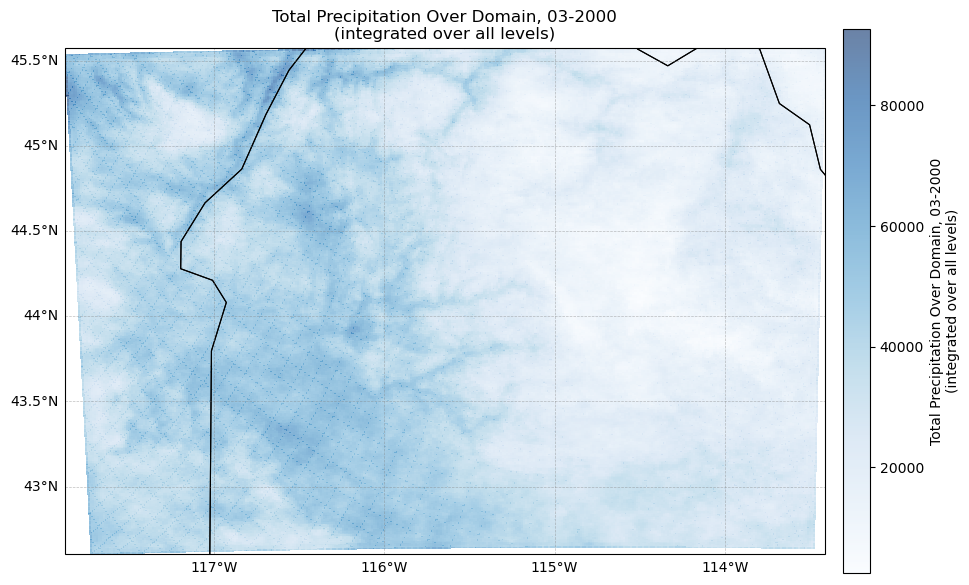

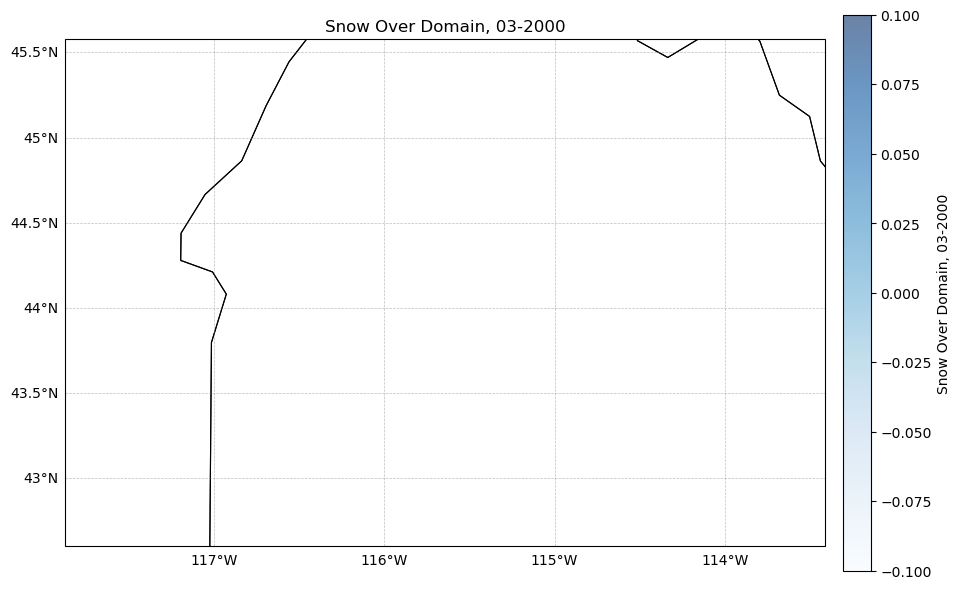

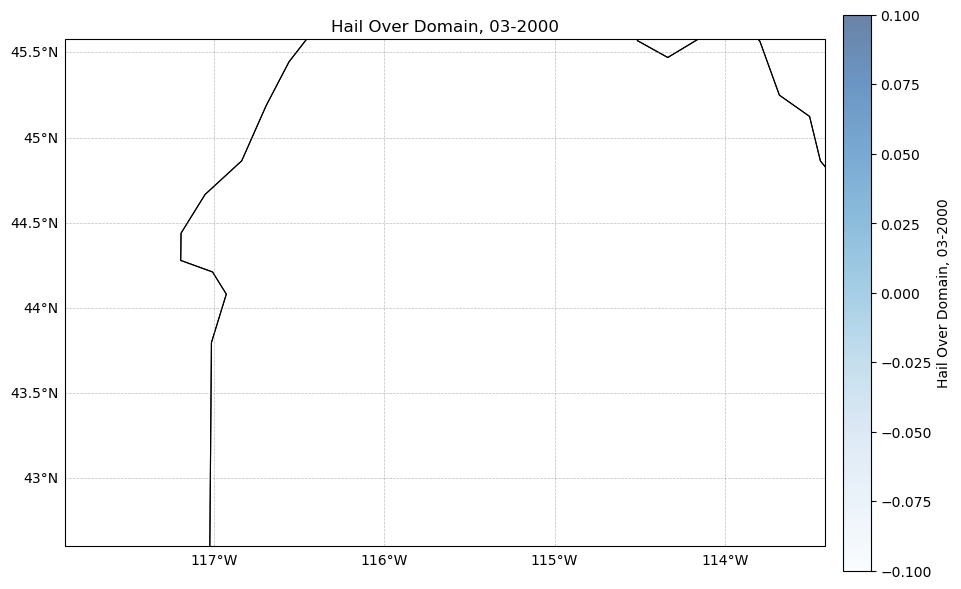

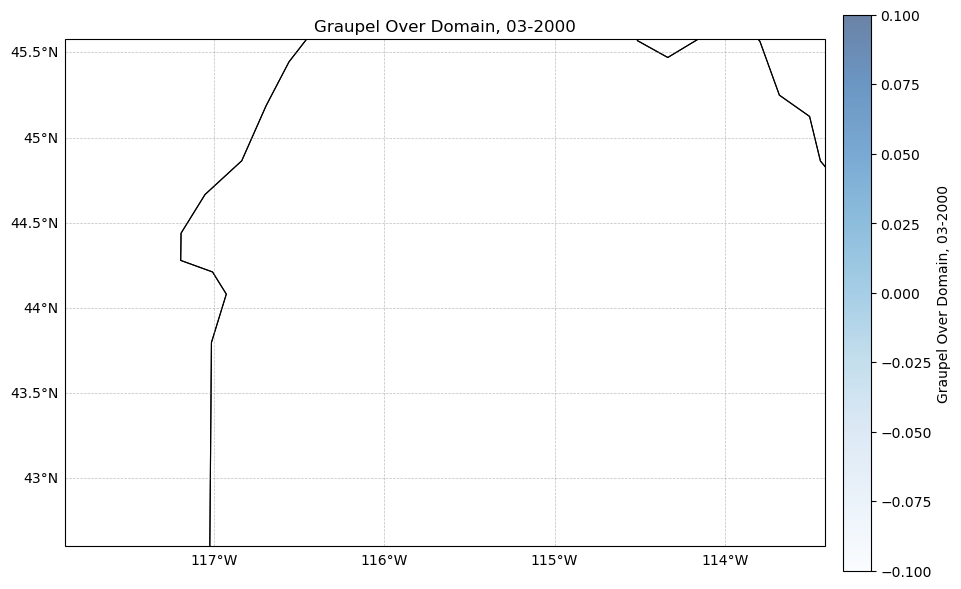

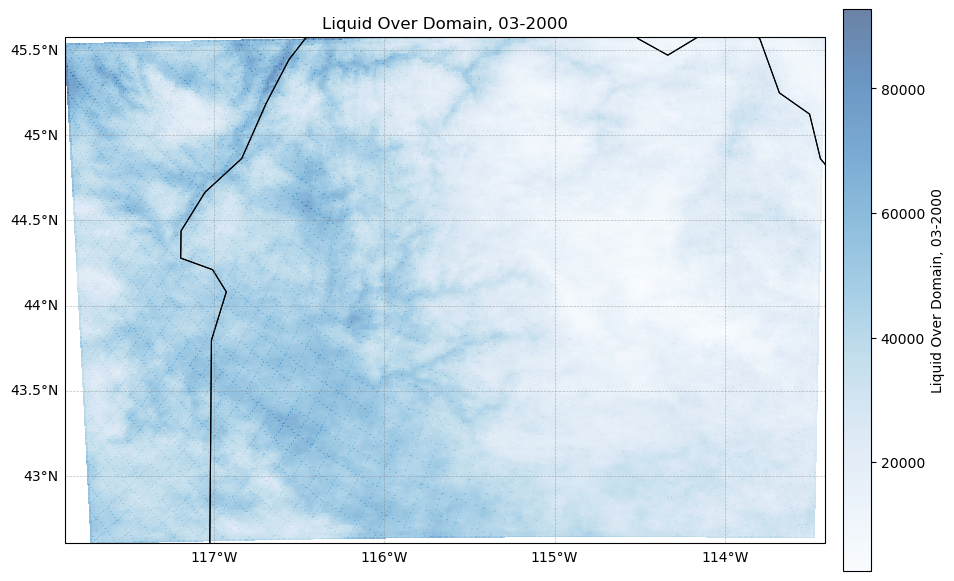

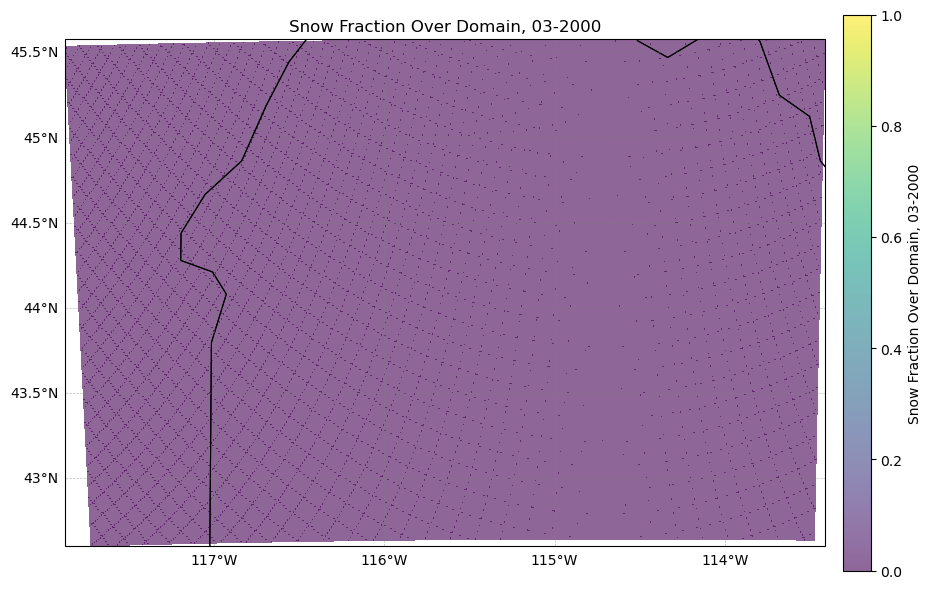

In [2]:
import numpy as np
import dask
import matplotlib.pyplot as plt
from importlib import reload
import plot_utils
reload(plot_utils)
from plot_utils import plot_cartopy, load_wrf_var, fix_accum_reset

# === DATA DIRECTORY ===
interpolated_dir = "/bsushare/leaf-shared/subset-output-wrf/lev_interpolated/vol04/wrf_out/wy_2000/d02"

# === CONFIGURATION ===
current_plot_file = interpolated_dir
month            = "03"
year             = "2000"
target_location  = "Domain"
epsilon          = 1e-6   # avoid division by zero
min_precip       = 1.0    # threshold for masking (mm)

# === LOAD DATA ===
t2_ds    = load_wrf_var("WRF_interp_T",    current_plot_file, year, month)
lats     = t2_ds["XLAT"][0].values
lons     = t2_ds["XLONG"][0].values

rain_ds  = load_wrf_var("WRF_interp_QRAIN", current_plot_file, year, month)
snow_ds  = load_wrf_var("WRF_interp_QSNOW", current_plot_file, year, month)
hail_ds  = load_wrf_var("WRF_interp_QICE",  current_plot_file, year, month)
graup_ds = load_wrf_var("WRF_interp_QGRAUP",current_plot_file, year, month)

# === CALCULATE TIME-INTEGRATED TOTALS ===
# fix_accum_reset sums over Time already (dims: level, south_north, west_east)
precip_vert = fix_accum_reset(rain_ds["QRAIN"])
# manually diff->clip->sum over Time for other species
snow_vert   = snow_ds["QSNOW"].diff(dim="Time").clip(min=0).sum(dim="Time")
hail_vert   = hail_ds["QICE"].diff(dim="Time").clip(min=0).sum(dim="Time")
graup_vert  = graup_ds["QGRAUP"].diff(dim="Time").clip(min=0).sum(dim="Time")

# === VERTICAL INTEGRATION ===
# now sum over 'level' dimension only
precip2d_da = precip_vert.sum(dim="level")
snow2d_da   = snow_vert.sum(dim="level")
hail2d_da   = hail_vert.sum(dim="level")
graup2d_da  = graup_vert.sum(dim="level")

# compute all four lazily in one go
precip2d, snow2d, hail2d, graup2d = dask.compute(
    precip2d_da, snow2d_da, hail2d_da, graup2d_da
)

# derive liquid and fraction in-memory
precip2d = precip2d.values
snow2d   = snow2d.values
hail2d   = hail2d.values
graup2d  = graup2d.values
liquid2d = precip2d - (snow2d + hail2d + graup2d)
frac2d   = snow2d / (precip2d + epsilon)

# === MASK LOW OR INVALID ===
precip2d_ma = np.ma.masked_less(precip2d, min_precip)
snow2d_ma   = np.ma.masked_less(snow2d,   min_precip)
hail2d_ma   = np.ma.masked_less(hail2d,   min_precip)
graup2d_ma  = np.ma.masked_less(graup2d,  min_precip)
liquid2d_ma = np.ma.masked_less(liquid2d, min_precip)
frac2d_ma   = np.ma.masked_invalid(frac2d)

# === PLOT RESULTS ===
plot_cartopy(
    lons, lats, precip2d_ma,
    f"Total Precipitation Over {target_location}, {month}-{year}\n(integrated over all levels)",
    cmap="Blues"
)

plot_cartopy(
    lons, lats, snow2d_ma,
    f"Snow Over {target_location}, {month}-{year}", cmap="Blues"
)

plot_cartopy(
    lons, lats, hail2d_ma,
    f"Hail Over {target_location}, {month}-{year}", cmap="Blues"
)

plot_cartopy(
    lons, lats, graup2d_ma,
    f"Graupel Over {target_location}, {month}-{year}", cmap="Blues"
)

plot_cartopy(
    lons, lats, liquid2d_ma,
    f"Liquid Over {target_location}, {month}-{year}", cmap="Blues"
)

plot_cartopy(
    lons, lats, frac2d_ma,
    f"Snow Fraction Over {target_location}, {month}-{year}", cmap="viridis", vmin=0, vmax=1
)
